# Decentralized Distributed Optimization

The target of the current work is to explore one of the efficient way of optimization, which is really popular nowadays - decentralized distributed optimization. Let's consider the modern approach to solution.

We are trying to solve such an optimization problem with sum-type functional
$$f^* = \min_{x \in \mathbb{R}^d}\left[f(x)\coloneqq \frac{1}{n}\sum \limits_{i=1}^{n}f_i(x)\right].$$
Each $f_i$ defined in stochastic form
$$f_i(x)\coloneqq \mathbb{E}_{\xi_i \sim \mathbb{D_i}}F_i(x, \xi_i),$$
where $\xi_i$ is a random variable with distribution $\mathbb{D_i}$.

It is important to note that we do not make any assumptions on the distributions $\mathbb{D_i}$. This means that we especially cover hard heterogeneous machine learning problems where data is only available locally to each worker $i \in [n] := {1, \ldots, n}$ and the local minima $x_i^*:=argmin_{x \in \mathbb{R^d}}f_i(x)$ can be far away from the global minimizer of $(1)$.

# Assumptions on the objective function $f$

For all our theoretical results we assume that $f$ is smooth.

$\textbf{Assumption 1a}$ ($L$-smoothness). Each function $F_i(x, \xi): \mathbb{R^d} \times \Omega_i \rightarrow \mathbb{R}, i \in [n]$ is differentiable for each $\xi \in supp(\mathbb{D_i})$ and there exists a constant $L \geq 0$ such that for each $\mathbf{x, y} \in \mathbb{R}, \xi \in supp(\mathbb{D_i}):$
$$\|\nabla F_i(\mathbf{y}, \xi) - \nabla F_i(\mathbf{x}, \xi)\| \leq L\|\mathbf{x - y}\|.$$

Sometimes it will be enough to just assume smoothness of $f_i$ instead.

$\textbf{Assumption 1b}$ ($L$-smoothness). Each function $f_i(x): \mathbb{R^d} \rightarrow \mathbb{R}, i \in [n]$ is differentiable and there exists a constant $L \geq 0$ such that for each $\mathbf{x, y} \in \mathbb{R}:$
$$\|\nabla f_i(\mathbf{y}, \xi) - \nabla f_i(\mathbf{x}, \xi)\| \leq L\|\mathbf{x - y}\|.$$

$\mathbf{Assumption\ 2}$ ($\mu$-convexity). Each function $f_i(x): \mathbb{R^d} \rightarrow \mathbb{R}, i \in [n]$ is $\mu$-(strongly) convex for constant $\mu \geq 0$. That is for all, $\mathbf{x, y} \in \mathbb{R^d}:$
$$f_i(x) - f_i(y) + \frac{\mu}{2}\|x-y\|_2^2\leq \langle\nabla f_i(x), x - y\rangle.$$

$\mathbf{Assumption 3a}$ (Bounded noise at the optimum). Let $\mathbf{x}^* = arg min f(\mathbf{x})$ and define
$$\zeta_i^2:= \|\nabla f_i(\mathbf{x^*})\|_2^2,\ \bar{\zeta}^2:=\frac{1}{n}\sum\limits_{i=1}^n\zeta_i^2,$$
$$\sigma_i^2:=\mathbb{E}_{\xi_i}\|\nabla F_i(\mathbf{x^*, \xi_i}) - \nabla f_i(\mathbf{x^*})\|_2^2,$$
$$\bar{\sigma}^2:=\frac{1}{n}\sum\limits_{i=1}^n\sigma_i^2.$$

Thus, $\bar{\sigma}^2$ measures the noise level, and $\bar{\zeta}^2$ the divirsity of the function $f_i$. We assume them to be bounded, but not everywhere, only at $\mathbb{x^*}$. For non-convex case we generalize Assumption 3a to:

$\mathbf{Assumption 3b}$ (Bounded noise). We assume that there exists constants $P, \hat{\zeta}$ such that $\forall x \in \mathbb{R^d}$,
$$\frac{1}{n}\sum\limits_{i=1}^{n}\|\nabla f_i(x)\|_2^2\leq\hat{\zeta^2} + P\|\nabla f(x)\|_2^2,$$
and constant $M, \hat{\sigma}$ such that $\forall x_1, \ldots, x_n \in \mathbb{R^d}$
$$\Psi \leq \hat{\sigma^2} + \frac{M}{n}\sum_{i = 1}^{n}\|\nabla f_i(x_i)\|_2^2,$$
$$where \Psi := \frac{1}{n} \sum\limits_{i = 1}^{n}\mathbb{E}_{\xi_i}\|\nabla F_i(x_i, \xi_i) - \nabla f_i(x_i)\|_2^2.$$

$\mathbf{Assumption\ 4}(Expected Consensus Rate). We assume that there exists two constants $p\in (0,1]$ and integer $\tau \geq 1$ such that for all matrices $X\in \mathbb{R^{d\times n}}$ and all integers $l\in\{0,\ldots, (l+1)\tau - 1\},$
$$\mathbb{E}_W\|XW_{l, \tau} - \bar{X}\|_F^2\leq(1-p)\|X-\bar{X}\|^2_F,$$
where $W_{l, \tau} = W^{((l + 1)\tau-1)}\ldots W^{(l\tau)}$ and $\bar{X}:=X\frac{\mathbf{11}^T}{n}$ and $\mathbb{E}$ is taken over the distributions $W^{(t)}\sim\mathbb{W^{(t)}}$ and indices $t \in \{l_{\tau},\ldots, (l + 1)\tau - 1\}.$

# Decentralized (Gossip) SGD

This method allows only decentralized communications. That is, the exchange of information (through gossip averaging) can only occur
between connected nodes (neighbors). The algorithm (outlined in Algorithm 1) consists of two phases: (i) stochastic
gradient updates, performed locally on each worker (lines
4–5), followed by a (ii) consensus operation, where nodes
average their values with their neighbors.

$$X^{(t + 1)} = X^{(t)}W^{(t)},$$

where the mixing matrix $W^{(t)} \in [0, 1]^{n\times n}$ encodes the network structure at time $t$.

Now, let's implement the algorithm itself.

In [26]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
from scipy import stats

import ray
try:
    ray.init()
except:
    pass

matplotlib.rcParams.update({'font.size': 16})

In [27]:
random_seed = 42
np.random.seed(random_seed)
# Define constant parameters

dim = 2                                     # Dimension of the vectors.
n = 2                                       # Number of functions f_i in the sum.
mixing_matrix_distr = \
lambda t : stats.expon(0, 1 / (t + 1) + 1).rvs             # Mixing matrix distribution. Should be a function of t.
T = 300

# Constants for functions F_1 and F_2:

A = np.eye(dim, dim) #+ np.random.normal(0, 1, (dim, dim))
B = np.eye(dim, dim)# + np.random.normal(0, 1, (dim, dim))
b = np.eye(dim, 1)# np.random.uniform(-2, 2, (dim, 1))

Let's define functions $F_1$ in the following way:
$$F_1(x, \xi)=\langle x, Ax\rangle + \langle x, b\rangle + \langle x, \xi\rangle$$

Now let's calculate the gradient of the function:
$$\nabla F_1(x, \xi) = (A + A^T)x + b + \xi$$

In [28]:
def F1(x, xi):
    return x.T @ A @ x + x.T @ b + x.T @ xi

def gradF1(x, xi):
    return (A + A.T) @ x + b + xi

Analogously, for $F_2$:
$$F_2(x, \xi)=\langle x, Bx\rangle - \langle x, \xi\rangle$$
$$\nabla F_2(x, \xi) = (B + B^T)x - \xi$$

In [29]:
def F2(x, xi):
        return x.T @ B @ x - x.T @ xi

def gradF2(x, xi):
    return (B + B.T) @ x - xi

# Approaches to choose the mixing matrix W

$\mathbf{Fixed\ Sampling\ Distribution.}$ The matrix $W$ is kept constant over the iterations. We can choose $W=\frac{1}{n}\mathbf{11}^T$, and recover $\mathbf{centralized\ mini-batch\ SGD}$, or choose arbitrary connected $W$, we recover $\mathbf{decentralized\ SGD}$.

Three common network topologies are: ring, 2-d torus and fully-connected.

In [30]:
def get_FC():
    return np.ones((dim, dim))

In [31]:
def mixing_matrix(distr):
    W = distr((n, n))                       # generate a random matrix from a given distribution
    U = np.triu(W, k = 1)                   # lower-triangle matrix
    diag = np.diag(np.diagonal(W))          # diagonal of the matrix W: (n * n)
    W = U + U.T + diag                      # make the symmetric matrix
    
    # normalize it, so the sum of the indeces in a column(and in a row, as it is symmetric) is euqal 1
    eps = 1e-4
    for i in range(n):
        left_sum = np.sum(W[i, 0 : i])
        right_sum = np.sum(W[i, i:])
        sum = right_sum / (1 - left_sum + eps)
        W[i, i + 1:] = W[i, i + 1:] / sum
        W[i:, i] = W[i:, i] / sum

    assert np.all(W == W.T)
    assert np.allclose(W @ np.ones((n, 1)), np.ones((n, 1)), atol=1e-3)
    assert np.allclose(np.ones((1, n)) @ W, np.ones((1, n)), atol=1e-3)
    assert np.all(W >= -eps) == np.all(W <= 1 + eps) 
    
    return W

In [32]:
np.random.seed(random_seed)

X = np.random.uniform(0, 1, (dim, n))
step_size = np.ones(T) * 0.01
gradF = [gradF1, gradF2]

In [33]:
D = stats.norm(0, 1).rvs

@ray.remote
def gradient_update(gradF, x_i, step):
    """
    In parallel (task for worker i)
    """
    xi_t = D(size=(dim, 1))
    g_i = gradF(x_i, xi_t)
    res = x_i - step * g_i
    return res, g_i

In [34]:
x_star = np.hstack([(-np.linalg.inv(A + A.T + B + B.T) @ b).reshape(-1, 1), np.array([0, 0]).reshape(-1, 1)])

def loss():
    return np.linalg.norm(X - x_star) ** 2

In [35]:
def draw(loss_hist):
    clear_output(wait=True)
    plt.figure(figsize=(15, 8))
    plt.title("Gradient graphic")
    plt.xlabel("#iteration")
    plt.ylabel("gradient norm")
    plt.yscale("linear")
    plt.plot(loss_hist, "c")
    plt.show()

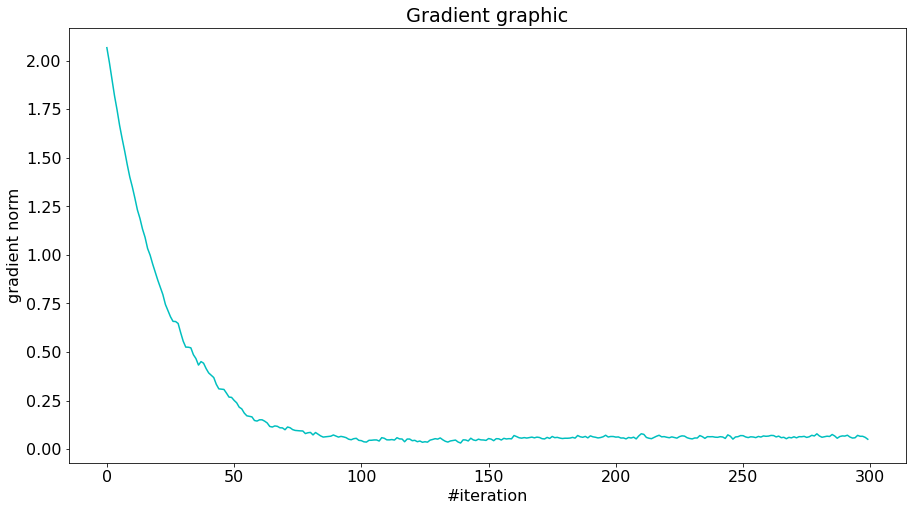

Grad: 0.05106277243681202


In [36]:
loss_history = []
for t in range(T):
    W_t = mixing_matrix(mixing_matrix_distr(t))
    upd_list = ray.get([gradient_update.remote(gradF[i], X[:, [i]], step_size[t]) for i in range(n)])
    X, grad = zip(*upd_list)
    X = np.array(X).reshape(dim, n)
    grad = np.mean(grad, axis=1, keepdims=True)
    grad = np.linalg.norm(grad)
    X = X @ W_t
    loss_history.append(loss())
    draw(loss_history)
print("Grad:", loss_history[-1])

Let's try $W = \frac{1}{d}E:$

In [37]:
np.random.seed(random_seed)

X = np.random.uniform(0, 1, (dim, n))
step_size = np.ones(T) * 0.01
gradF = [gradF1, gradF2]

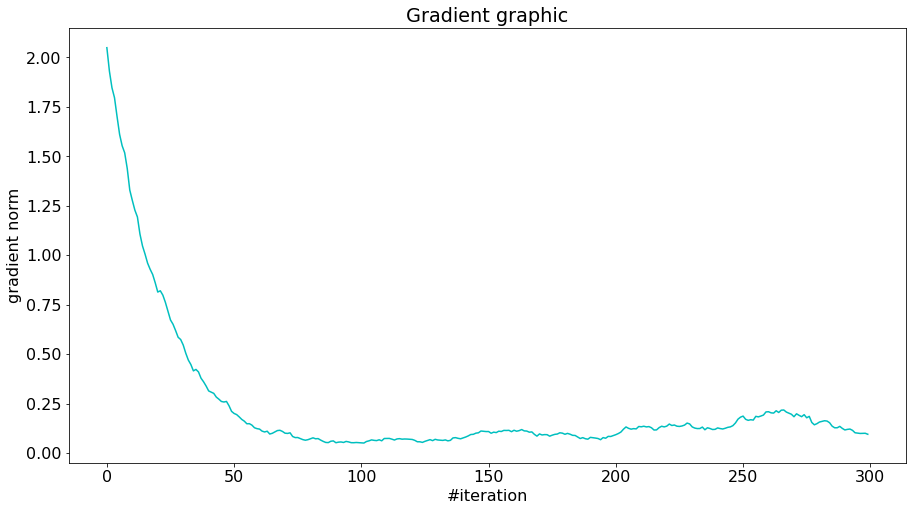

Grad: 0.09497230499698107


In [38]:
loss_history = []
for t in range(T):
    W_t = np.eye(dim, dim)
    upd_list = ray.get([gradient_update.remote(gradF[i], X[:, [i]], step_size[t]) for i in range(n)])
    X, grad = zip(*upd_list)
    X = np.array(X).reshape(dim, n)
    grad = np.mean(grad, axis=1, keepdims=True)
    grad = np.linalg.norm(grad)
    X = X @ W_t
    loss_history.append(loss())
    draw(loss_history)
print("Grad:", loss_history[-1])

# Results

We can achieve good results, varying some parameters.